In [1]:
from IPython.display import display
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import gzip
import os
import csv
from alive_progress import alive_bar
from collections import defaultdict


c:\Users\bincl\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [50]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, element_at, slice, size, regexp_extract, transform, when, explode, \
monotonically_increasing_id, map_from_arrays, lit, udf,collect_list, row_number, ceil, map_keys, expr, from_json
from pyspark.sql.types import ShortType, ArrayType, LongType, StringType
from pyspark.sql import types as T

import pandas as pd

#path = 'C:/Users/bincl/BA-Thesis/Dataset/2gram/2_20000_nopos_ab.gz'
start_date = 1800
end_date = 2000
path = 'C:/Users/bincl/BA-Thesis/Dataset/3gram/3_20000_nopos_sample/3_20000_nopos_sample.gz'
directory_par = 'C:/Users/bincl/BA-Thesis/Dataset/2gram/parquet/'

spark = SparkSession.builder.appName('3gramSQL').getOrCreate()

raw_input_df = spark \
                .read.csv(path, sep='\n',quote="").withColumnRenamed('_c0', 'Input')

split_df = raw_input_df \
                .select(split('Input', '\t').alias('SplitInput')) \
                .select(element_at('SplitInput', 1).alias('Tokens'),
                        slice('SplitInput', 2,
size('SplitInput')).alias('Data')) \
                .select('Tokens', 'Data') \

df_3gram = split_df.select('Tokens', transform('Data', lambda d:
split(d, ',')).alias('Data')) \
                .select('Tokens', transform('Data', lambda x:
x[0]).alias('Year'),
                        transform('Data', lambda x:
x[1]).cast(ArrayType(LongType())).alias('Occurrences')) \
                .select('Tokens', map_from_arrays('Year',
'Occurrences').alias('Data')) \
                .select(['Tokens', 'Data'])              

In [51]:

df_2gram = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(directory_par)      

In [52]:
# if id set as default parameter then a list is given if not a spark dataframe is given as parameter df
def get_pd_df(df):
    
    matched = df['Data'] 
    matched_pandas_df = pd.Series(matched)
    matched_pandas_df.sort_index(inplace = True)

    matched_pandas_df.index.astype('int')
    numbers = list(range(start_date,end_date))
    numbers = map(str, numbers)
    matched_pandas_df = matched_pandas_df.reindex(numbers, fill_value= 0)
    return matched_pandas_df

def get_pd_df_from_string(suchstring, df):
    x = df.select(['Tokens', 'Data']).where(df.Tokens == suchstring)
    matched = x.first()['Data']
    matched_pandas_df = pd.Series(matched)
    matched_pandas_df.sort_index(inplace = True)

    matched_pandas_df.index.astype('int')
    numbers = list(range(start_date,end_date))
    numbers = map(str, numbers)
    matched_pandas_df = matched_pandas_df.reindex(numbers, fill_value= 0)
    return matched_pandas_df

In [53]:
# deprecated zu langsam
def find_n_gram(direc, find):
    for filename in os.listdir(direc):
        f = os.path.join(direc, filename)
        # checking if it is a file
        if os.path.isfile(f):
            with gzip.open(f,'rt', encoding='utf-8') as input:
                str_arr_csv = input.readlines()
                for line in str_arr_csv:
                    token = line.split("\t")
                    if find == token[0]:
                        return line
                        
    return "line not found" 

def start_the_search(directory,search):
    result = find_n_gram(directory,search)
    
    if result == "line not found":
        print(result)
        exit()
    result = result.split("\t")
    lower_ngram = pd.Series(result[1:],dtype= "string", name = result[0])
    return lower_ngram

In [54]:
def getLowerLevelString(string):
   first, *middle, last = string.split()
   first = first + " " + ''.join(middle)
   last = ''.join(middle) + " " + last
   return first, last

def MLR(data):
    token = data['Tokens']
    first,last = getLowerLevelString(token)
    first = get_pd_df_from_string(first,df_2gram)
    last = get_pd_df_from_string(last,df_2gram)
    
    X = pd.concat([first,last],axis=1)
    y = get_pd_df(data)
    reg = LinearRegression()
    reg.fit(X, y) 
    
    return reg.coef_,reg.intercept_,X,y

def buildApproximation(c1,c2,basevalue,df):
    df = df.astype('float')
    df['scaledFirst'] = df.iloc[:,0].apply(lambda x: x * c1) 
    df['scaledLast'] = df.iloc[:,1].apply(lambda x: x * c2) 
    df['approximation'] = df['scaledFirst'] + df['scaledLast'] + basevalue
    return df

In [55]:
def compressWithError2gram(n,error):
    df_3_gram = df_3gram.head(n)
    result = []
    all = []
    sum = []
    firstN = range(0,n)
    
    with alive_bar(len(firstN), force_tty = True, bar = 'smooth') as bar:
        for i in firstN:
            data = df_3_gram[i]
            token = data['Tokens']
            coef,intercept,dfAprox,original = MLR(data)
            c1,c2 = coef
            df = buildApproximation(c1,c2,intercept,dfAprox)
            dfOriginal = pd.DataFrame()
            dfOriginal['values'] = original
            dfOriginal['values'] = dfOriginal['values'].apply(pd.to_numeric, errors='coerce')
            #dfOriginal= pd.to_numeric(dfOriginal)
            dfOriginal['zscore'] = zscore(dfOriginal)
            df['zscore'] = zscore(df['approximation'])
            
            sum.append(pd.to_numeric(dfOriginal['values']).sum()) 
            
            rmse = mean_squared_error(dfOriginal['zscore'], df['zscore'], squared = False)
            #rmse = mean_squared_error(dfOriginal, df['approximation'])
            if rmse <= error:
                result.append([token,rmse,dfOriginal['values'],dfOriginal['zscore'],df['approximation'],df['zscore']]) 
            all.append(rmse)    
            bar()
    return result, all, sum


In [79]:
result, all, sum = compressWithError2gram(200, 1)
print(sum)
print(all)
print(len(result))

|████████████████████████████████████████| 200/200 [100%] in 5:37.8 (0.59/s)    
[44, 53, 54, 2857, 94, 75, 67, 47, 31, 1176, 111, 106, 116, 171, 418, 159, 104, 29, 7, 285, 78, 147, 1778, 92, 169, 44, 217, 189, 170, 150, 1, 78, 22, 26, 216, 398, 63, 77, 93, 45, 29, 122, 301, 53, 61, 47, 14, 158, 44, 13, 1030, 810, 65, 38, 72, 105, 84, 106, 55, 381, 1465, 170, 233, 163, 433, 43, 116, 48, 133, 595, 33, 337, 117, 39, 73, 958, 12121, 123, 88, 50, 59, 215, 68, 90, 144, 48, 169, 22, 104, 79, 394, 136, 105, 3445, 170, 723, 2822, 102, 36, 3220, 85, 4057, 73, 473, 560, 31, 1301, 106, 300, 766, 159, 209, 26, 43, 33, 80, 38, 14, 41, 745, 390, 48, 58, 41, 41, 374, 139, 371, 73, 44, 123, 111, 42, 686, 2670, 462, 115, 125, 16, 105, 78, 60, 127, 485, 36, 43, 41, 66, 344, 297, 41, 107, 111, 538, 431, 44, 27, 147, 120, 308, 2204, 224, 39, 169, 334, 43, 52, 40, 46, 160, 121, 41, 66, 44, 39, 280, 47, 56, 772, 38, 3213, 274, 91, 90, 437, 66, 484, 46, 6563, 1776, 29, 106, 110, 3204, 3647, 918, 97, 56, 1784

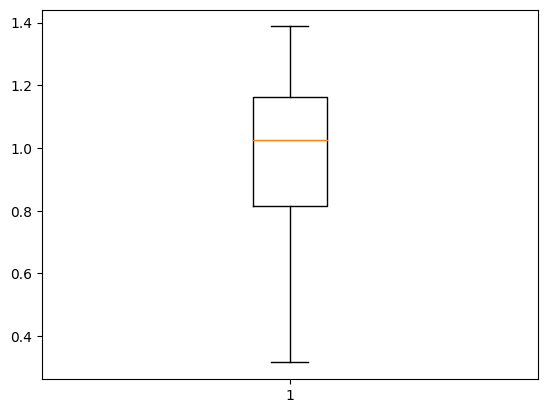

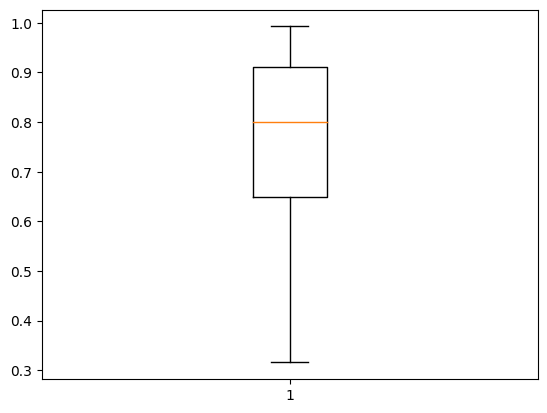

<AxesSubplot: >

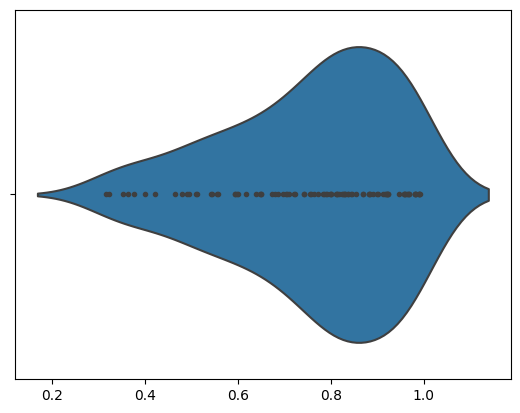

In [80]:
plt.boxplot(all)
plt.show()
rmse_with_error = []

for i in result:
    rmse_with_error.append(i[1])
plt.boxplot(rmse_with_error)
plt.show()

import seaborn as sns

sns.violinplot(x= rmse_with_error, inner="point")

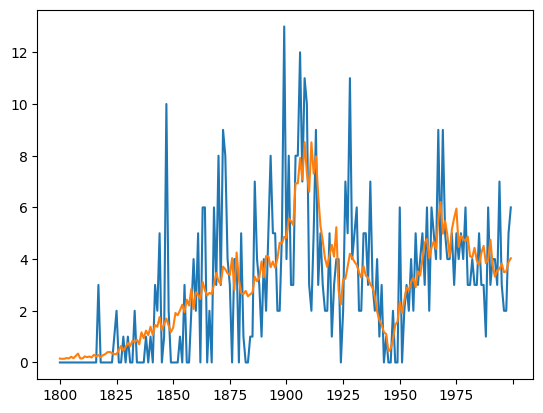

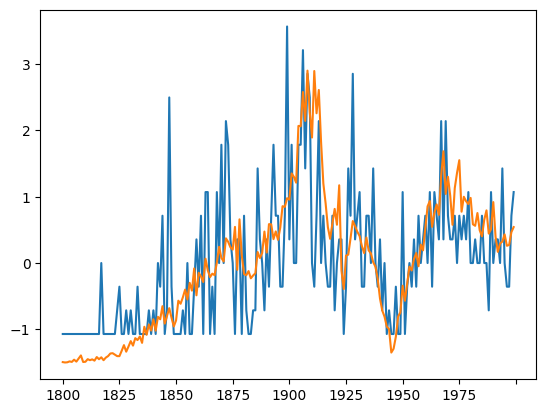

" ) ausgedehnt


In [84]:
n = 0
result[n][2].plot()
result[n][4].plot()
plt.show()
result[n][3].plot()
result[n][5].plot()
plt.show()
print(result[n][0])


<AxesSubplot: >

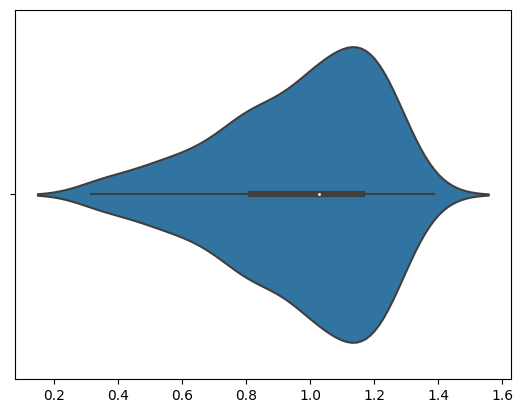

In [82]:
sns.violinplot(x= all, inner_kws=dict(box_width=15, whis_width=2, color=".8"))

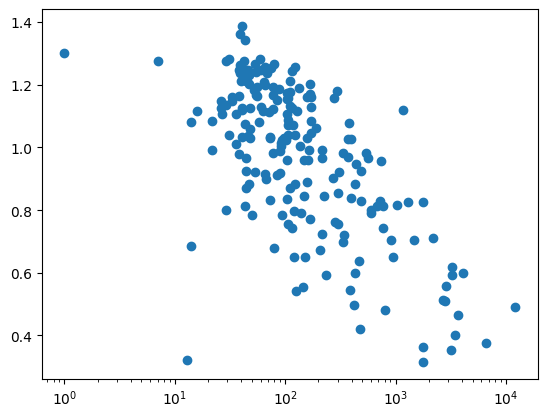

In [83]:

plt.scatter(sum, all)
plt.xscale('log')
plt.show()